<h1>importing dataset from yahoo finance

In [1]:
import pandas as pd
import numpy as np
import keras as kf
from keras.models import load_model
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")
%matplotlib inline

# For reading stock data from yahoo
from pandas_datareader.data import DataReader
import yfinance as yf
from pandas_datareader import data as pdr

yf.pdr_override()

# For time stamps
from datetime import datetime


# The tech stocks we'll use for this analysis
tech_list = ['AAPL', 'GOOG', 'MSFT', 'AMZN']

# Set up End and Start times for data grab
tech_list = ['AAPL', 'GOOG', 'MSFT', 'AMZN']

end = datetime.now()
start = datetime(end.year - 1, end.month, end.day)

for stock in tech_list:
    globals()[stock] = yf.download(stock, start, end)
    

company_list = [AAPL, GOOG, MSFT, AMZN]
company_name = ["APPLE", "GOOGLE", "MICROSOFT", "AMAZON"]

for company, com_name in zip(company_list, company_name):
    company["company_name"] = com_name
    
df = pd.concat(company_list, axis=0)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


<h3>Describing dataset fetched from yfinance 

In [2]:
AAPL.describe()

,Open,High,Low,Close,Adj Close,Volume
count,251.000000,251.000000,251.000000,251.000000,251.000000,2.510000e+02
mean,181.066773,182.530797,179.737689,181.219482,180.796576,5.749160e+07
std,8.897479,8.748629,8.818818,8.786131,8.804264,1.779585e+07
min,163.059998,165.279999,162.800003,163.759995,162.890533,1.783411e+07
25%,173.240005,174.905006,172.050003,173.735001,173.305122,4.657160e+07
50%,180.669998,182.229996,178.550003,180.710007,180.238220,5.363130e+07
75%,189.294998,189.990005,187.695000,189.334999,188.909798,6.267560e+07
max,198.020004,199.619995,197.000000,198.110001,197.857529,1.366826e+08


In [3]:

df = pdr.get_data_yahoo('AAPL', start='2012-01-01', end=datetime.now())
# Show teh data
df

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2012-01-03,14.621429,14.732143,14.607143,14.686786,12.433825,302220800
2012-01-04,14.642857,14.810000,14.617143,14.765714,12.500643,260022000
2012-01-05,14.819643,14.948214,14.738214,14.929643,12.639427,271269600
2012-01-06,14.991786,15.098214,14.972143,15.085714,12.771558,318292800
2012-01-09,15.196429,15.276786,15.048214,15.061786,12.751295,394024400
...,...,...,...,...,...,...
2024-04-09,168.699997,170.080002,168.350006,169.669998,169.669998,42451200
2024-04-10,168.800003,169.089996,167.110001,167.779999,167.779999,49709300
2024-04-11,168.339996,175.460007,168.160004,175.039993,175.039993,91070300


<h4>plotting graph for price history of apple

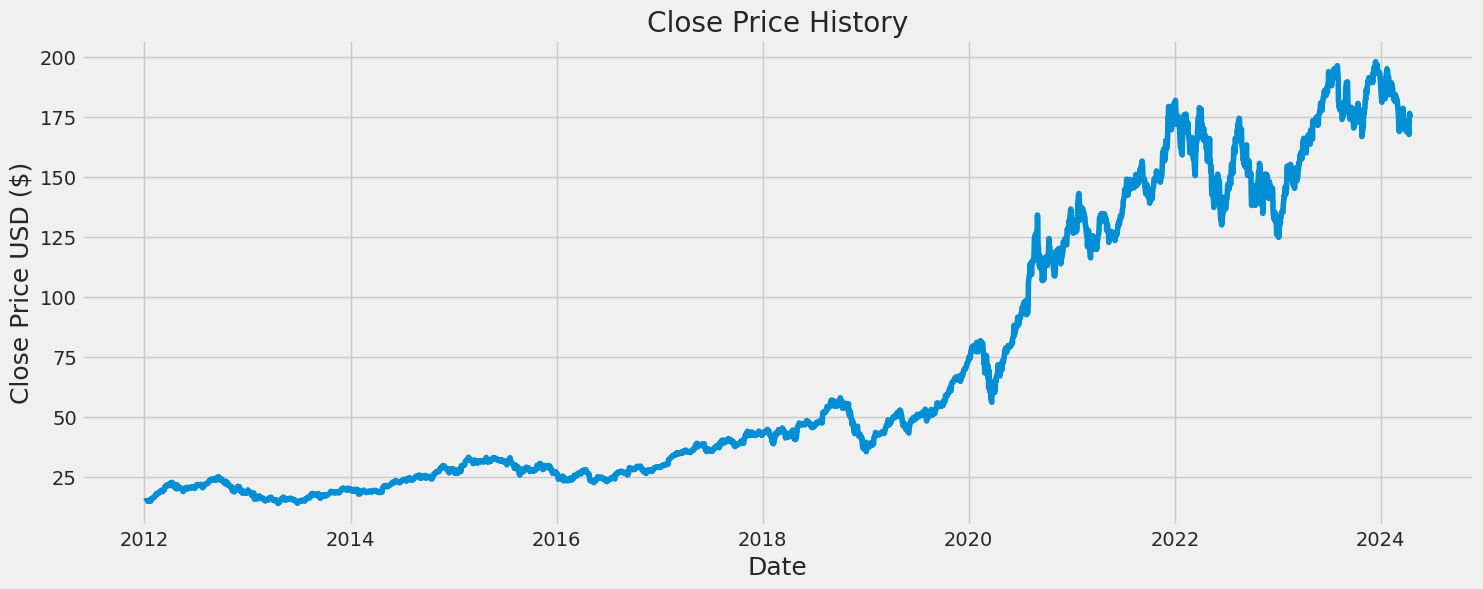

In [4]:
plt.figure(figsize=(16,6))
plt.title('Close Price History')
plt.plot(df['Close'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.show()

In [5]:
# Create a new dataframe with only the 'Close column 
data = df.filter(['Close'])
# Convert the dataframe to a numpy array
dataset = data.values
# Get the number of rows to train the model on
training_data_len = int(np.ceil( len(dataset) * .95 ))

training_data_len

2936

In [6]:
dataset

array([[ 14.6867857 ],
       [ 14.76571369],
       [ 14.92964268],
       ...,
       [175.03999329],
       [176.55000305],
       [174.85499573]])

<h5>transforming data using minmaxscaler

In [7]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

scaled_data

array([[0.00401431],
       [0.00444289],
       [0.00533302],
       ...,
       [0.87473016],
       [0.88292949],
       [0.87372562]])

In [33]:
# Create the training data set 
# Create the scaled training data set
train_data = scaled_data[0:int(training_data_len), :]
# Split the data into x_train and y_train data sets
x_train = []
y_train = []

n_forecast = 5
n_lookback = 120

for i in range(n_lookback, len(train_data)-n_forecast+1):
    x_train.append(train_data[i-n_lookback:i])
    y_train.append(train_data[i : i+n_forecast])
        
# Convert the x_train and y_train to numpy arrays 
x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape the data
# x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
y_train.shape

(2812, 5, 1)

In [34]:
# generate the input and output sequences
n_lookback = 120  # length of input sequences (lookback period)
n_forecast = 5  # length of output sequences (forecast period)

X = []
Y = []

for i in range(n_lookback, len(train_data) - n_forecast + 1):
    X.append(train_data[i - n_lookback: i])
    Y.append(train_data[i: i + n_forecast])

X = np.array(X)
Y = np.array(Y)
# X.shape
Y.shape

(2812, 5, 1)

<h3>training lstm model on our dataset

In [37]:
from keras.models import Sequential
from keras.layers import Dense, LSTM

# Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(n_lookback, 1)))
model.add(LSTM(units=50))
model.add(Dense(n_forecast))

# model.compile(loss='mean_squared_error', optimizer='adam')
# model.fit(X, Y, epochs=100, batch_size=32, verbose=0)

# Compile the model
model.compile(loss='mean_squared_error', optimizer='adam')

# # Train the model
model.fit(X, Y,epochs=15, batch_size=8)

Epoch 1/15
352/352 [==============================] - 13s 27ms/step - loss: 0.0036
Epoch 2/15
352/352 [==============================] - 9s 26ms/step - loss: 6.6860e-04
Epoch 3/15
352/352 [==============================] - 9s 25ms/step - loss: 6.3837e-04
Epoch 4/15
352/352 [==============================] - 9s 26ms/step - loss: 5.1973e-04
Epoch 5/15
352/352 [==============================] - 9s 25ms/step - loss: 4.9957e-04
Epoch 6/15
352/352 [==============================] - 9s 25ms/step - loss: 5.3164e-04
Epoch 7/15
352/352 [==============================] - 9s 24ms/step - loss: 4.6202e-04
Epoch 8/15
352/352 [==============================] - 9s 25ms/step - loss: 3.4998e-04
Epoch 9/15
352/352 [==============================] - 9s 24ms/step - loss: 3.4473e-04
Epoch 10/15
352/352 [==============================] - 9s 25ms/step - loss: 3.4979e-04
Epoch 11/15
352/352 [==============================] - 9s 25ms/step - loss: 3.4644e-04
Epoch 12/15
352/352 [==============================] - 

In [38]:
X_ = train_data[- n_lookback:]  # last available input sequence
X_ = X_.reshape(1, n_lookback, 1)

Y_ = model.predict(X_).reshape(-1, 1)
Y_ = scaler.inverse_transform(Y_)

1/1 [==============================] - 1s 697ms/step


In [39]:
df = yf.download(tickers=['AAPL'], period='1y')
y = df['Close'].fillna(method='ffill')
y = y.values.reshape(-1, 1)

[*********************100%%**********************]  1 of 1 completed
/tmp/ipykernel_1454/693878495.py:2: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  y = df['Close'].fillna(method='ffill')


<h3>forecasting future value

/tmp/ipykernel_1454/933578642.py:5: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df_past['Forecast'].iloc[-1] = df_past['Actual'].iloc[-1]
/tmp/ipykernel_1454/933578642.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of

<Axes: title={'center': 'AAPL'}, xlabel='Date'>

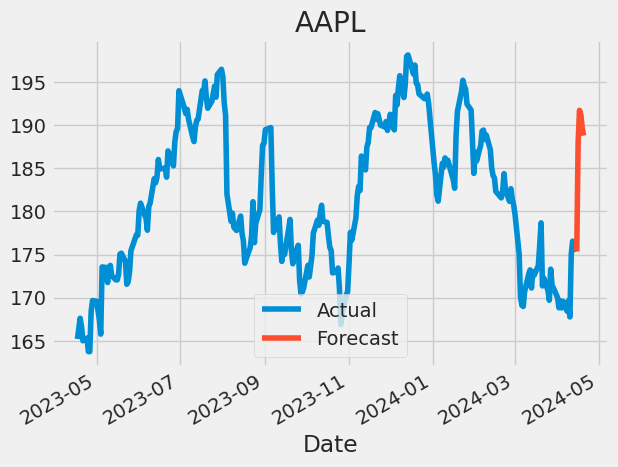

In [40]:
df_past = df[['Close']].reset_index()
df_past.rename(columns={'index': 'Date', 'Close': 'Actual'}, inplace=True)
df_past['Date'] = pd.to_datetime(df_past['Date'])
df_past['Forecast'] = np.nan
df_past['Forecast'].iloc[-1] = df_past['Actual'].iloc[-1]

df_future = pd.DataFrame(columns=['Date', 'Actual', 'Forecast'])
df_future['Date'] = pd.date_range(start=df_past['Date'].iloc[-1] + pd.Timedelta(days=1), periods=n_forecast)
df_future['Forecast'] = Y_.flatten()
df_future['Actual'] = np.nan

results = df_past._append(df_future).set_index('Date')
# results = pd.concat([df_past, pd.DataFrame([df_future])]).set_index('Date')

# plot the results
results.plot(title='AAPL')



In [41]:
df_future

,Date,Actual,Forecast
0,2024-04-16,NaN,187.917145
1,2024-04-17,NaN,191.699707
2,2024-04-18,NaN,191.182510
3,2024-04-19,NaN,189.662170
4,2024-04-20,NaN,188.767258


<h3>checking root mean squared error

In [42]:
# Create the testing data set
# Create a new array containing scaled values from index 1543 to 2002 
test_data = scaled_data[training_data_len - 60: , :]
# Create the data sets x_test and y_test
x_test = []
y_test = dataset[training_data_len:, :]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])
    
# Convert the data to a numpy array
x_test = np.array(x_test)

# Reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

# Get the models predicted price values 
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

# Get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
rmse


5/5 [==============================] - 1s 11ms/step


2.9859759489285813

<h2>saving the model

In [51]:
model.save("stock_model.h5")
model2 = load_model("stock_model.h5")

/home/umair123/anaconda3/envs/py310/lib/python3.11/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


<h3>testing the saved model

In [61]:
X_ = train_data[- n_lookback:]  # last available input sequence
X_ = X_.reshape(1, n_lookback, 1)

Y_ = model2.predict(X_).reshape(-1, 1)
Y_ = scaler.inverse_transform(Y_)

df = yf.download(tickers=['AAPL'], period='1y')
y = df['Close'].fillna(method='ffill')
y = y.values.reshape(-1, 1)

1/1 [==============================] - 0s 20ms/step


[*********************100%%**********************]  1 of 1 completed
/tmp/ipykernel_1454/4162657880.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  y = df['Close'].fillna(method='ffill')


/tmp/ipykernel_1454/2714654194.py:5: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df_past['Forecast'].iloc[-1] = df_past['Actual'].iloc[-1]
/tmp/ipykernel_1454/2714654194.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy 

,Date,Actual,Forecast
0,2024-04-16,NaN,187.917145
1,2024-04-17,NaN,191.699707
2,2024-04-18,NaN,191.182510
3,2024-04-19,NaN,189.662170
4,2024-04-20,NaN,188.767258


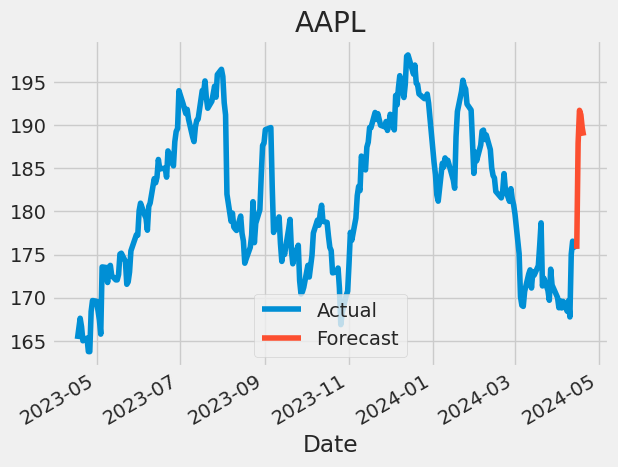

In [63]:
df_past = df[['Close']].reset_index()
df_past.rename(columns={'index': 'Date', 'Close': 'Actual'}, inplace=True)
df_past['Date'] = pd.to_datetime(df_past['Date'])
df_past['Forecast'] = np.nan
df_past['Forecast'].iloc[-1] = df_past['Actual'].iloc[-1]

df_future = pd.DataFrame(columns=['Date', 'Actual', 'Forecast'])
df_future['Date'] = pd.date_range(start=df_past['Date'].iloc[-1] + pd.Timedelta(days=1), periods=n_forecast)
df_future['Forecast'] = Y_.flatten()
df_future['Actual'] = np.nan

results = df_past._append(df_future).set_index('Date')
# results = pd.concat([df_past, pd.DataFrame([df_future])]).set_index('Date')

# plot the results
results.plot(title='AAPL')
df_future

In [64]:
# Create the testing data set
# Create a new array containing scaled values from index 1543 to 2002 
test_data = scaled_data[training_data_len - 60: , :]
# Create the data sets x_test and y_test
x_test = []
y_test = dataset[training_data_len:, :]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])
    
# Convert the data to a numpy array
x_test = np.array(x_test)

# Reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

# Get the models predicted price values 
predictions = model2.predict(x_test)
predictions = scaler.inverse_transform(predictions)

# Get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
rmse

5/5 [==============================] - 0s 9ms/step


2.9859759489285813